### Import required packages and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from pandas.tseries.offsets import BusinessDay
import pandas_datareader.data as web
import warnings
warnings.filterwarnings("ignore")
from functions import delta_hedging, calendar_to_business_days, create_straddles, process_straddles

### Initialize important dates

In [2]:
start_date = '2007-01-01'
end_date = '2023-09-30'

training_start_date = '2007-01-01'
training_end_date = '2015-12-31'
test_start_date = '2016-01-01'
test_end_date = '2023-08-31'

### Fetch and Process S&P prices data

In [3]:
sp = yf.download('^SPX')

sp.index = pd.to_datetime(sp.index)

# Filter the DataFrame
filtered_sp = sp.loc[start_date:end_date]

# Remove the ticker level from the multi index
filtered_sp.columns = filtered_sp.columns.droplevel(1)
filtered_sp = pd.DataFrame(filtered_sp['Close'], index=filtered_sp.index)
filtered_sp.index = pd.to_datetime(filtered_sp.index).tz_localize(None)

[*********************100%***********************]  1 of 1 completed


### Fetch and Process Fama French Risk free rate data

In [4]:
# Fetch the Fama-French 3-factor data
ff_data = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start_date, end_date)

# Convert period index to datetime
rf_data = ff_data[0]  # Extract the first dataframe (RF)
rf_data.index = rf_data.index.to_timestamp()  

# Select the RF column (risk-free rate)
risk_free_rate = pd.DataFrame(rf_data['RF'])

# Resample to daily frequency, forward-fill missing values (public holidays), and annualize the risk free rate
risk_free_rate = risk_free_rate.resample('D').ffill()
risk_free_rate = risk_free_rate * 12 / 100

### Reindex data to forward fill prices and risk free for public holidays

In [5]:
market_df = filtered_sp.merge(risk_free_rate, left_index=True, right_index=True)

# Create a new business day index
new_index = pd.bdate_range(start=start_date, end=end_date)

# Create a new DataFrame with the business day index
real_market_df = pd.DataFrame(index=new_index)

# Merge the existing market_df with the new DataFrame
real_market_df = real_market_df.merge(market_df, left_index=True, right_index=True, how='left')

# Forward fill the missing values
real_market_df.ffill(inplace=True)

# Rename the index to 'Date' if necessary
real_market_df.index.name = 'Date'

# Display the updated DataFrame
real_market_df

,Close,RF
Date,,
2007-01-01,NaN,NaN
2007-01-02,NaN,NaN
2007-01-03,1416.599976,0.0528
2007-01-04,1418.339966,0.0528
2007-01-05,1409.709961,0.0528
...,...,...
2023-09-25,4515.770020,0.0516
2023-09-26,4515.770020,0.0516
2023-09-27,4515.770020,0.0516


### Read Option data

In [6]:
# Read data from CSV
data = pd.read_csv('filtered_data2.csv')
data.set_index('Date', inplace=True)

### Define training and testing data

In [7]:
data_train = data[training_start_date:training_end_date]
option_df_train = data_train

data_test = data[test_start_date:test_end_date]
option_df_test = data_test

### Compute MidPrice and convert calendar days to business days

In [8]:
# Get midprice for all data
data_train['Midprice'] = (data_train['best_bid'] + data_train['best_offer']) / 2
data_test['Midprice'] = (data_test['best_bid'] + data_test['best_offer']) / 2

# convert calendar to business days
option_df_train['Business_Days_to_Expiration'] = option_df_train.apply(lambda row: calendar_to_business_days(row.name, row['exdate'], row['D to Expiration']), axis=1)
option_df_test['Business_Days_to_Expiration'] = option_df_test.apply(lambda row: calendar_to_business_days(row.name, row['exdate'], row['D to Expiration']), axis=1)

### Keep only options with 1 month or more to maturity

In [9]:
data_1m_train = data_train[data_train['Business_Days_to_Expiration'] >= 22]
data_1m_train.index = pd.to_datetime(data_1m_train.index)

data_1m_test = data_test[data_test['Business_Days_to_Expiration'] >= 22]
data_1m_test.index = pd.to_datetime(data_1m_test.index)

In [10]:
data_1m_train

,exdate,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,delta,gamma,optionid,contract_size,D to Expiration,Close,Moneyness,Midprice,Business_Days_to_Expiration
Date,,,,,,,,,,,,,,,,
2007-01-09,2007-02-17,C,1425.0,14.6,16.2,1566,0.099818,0.455103,0.008711,32304269,100,39,1412.109985,1.009128,15.40,29
2007-01-09,2007-02-17,C,1430.0,12.2,13.8,221,0.098095,0.410637,0.008697,32309398,100,39,1412.109985,1.012669,13.00,29
2007-01-09,2007-02-17,C,1435.0,10.0,11.6,184,0.096213,0.365685,0.008576,32309402,100,39,1412.109985,1.016210,10.80,29
2007-01-09,2007-02-17,C,1440.0,8.3,9.3,220,0.094129,0.320593,0.008341,32303409,100,39,1412.109985,1.019751,8.80,29
2007-01-09,2007-02-17,C,1445.0,6.6,7.6,61,0.092452,0.277198,0.007950,32303408,100,39,1412.109985,1.023291,7.10,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31,2016-02-05,P,1920.0,12.1,12.5,96,0.211088,-0.165773,0.001837,109720047,100,36,2043.939941,0.939362,12.30,26
2015-12-31,2016-02-05,P,1925.0,12.7,13.1,49,0.209026,-0.173527,0.001910,109720048,100,36,2043.939941,0.941808,12.90,26
2015-12-31,2016-02-05,P,1940.0,14.7,15.1,13,0.202866,-0.199030,0.002143,109720051,100,36,2043.939941,0.949147,14.90,26


### Create Straddles for each dates

In [11]:
# Group the data by date, strike price, and expiration date
groups_train = data_1m_train.groupby(['Date', 'strike_price', 'Business_Days_to_Expiration'])
groups_test = data_1m_test.groupby(['Date', 'strike_price', 'Business_Days_to_Expiration'])

straddles_df_train = create_straddles(groups_train)
straddles_df_test = create_straddles(groups_test)

In [12]:
straddles_df_test

,Strike_Price,D to Expiration,Call_Midprice,Put_Midprice,Contract Size,Initial Proceeds,Underlying Price,Call_Delta,Put_Delta,Call_Optionid,Put_Optionid,Moneyness
Date,,,,,,,,,,,,
2016-01-04,1830.0,29,186.35,10.45,100,196.80,2012.660034,0.873377,-0.122999,109769466,109769648,0.909244
2016-01-04,1850.0,29,168.30,12.40,100,180.70,2012.660034,0.851430,-0.144999,109769470,109769652,0.919182
2016-01-04,1860.0,29,159.35,13.60,100,172.95,2012.660034,0.839430,-0.157899,109769472,109769654,0.924150
2016-01-04,1865.0,29,155.10,14.25,100,169.35,2012.660034,0.831967,-0.164777,109769473,109769655,0.926634
2016-01-04,1875.0,24,144.75,12.00,100,156.75,2012.660034,0.839585,-0.156610,109719857,109720038,0.931603
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-30,4435.0,22,125.60,30.25,100,155.85,4514.870117,0.728967,-0.277773,154635930,154635934,0.982310
2023-08-30,4510.0,27,82.10,57.35,100,139.45,4514.870117,0.569958,-0.431375,156186939,156187017,0.998921
2023-08-30,4515.0,23,70.95,54.40,100,125.35,4514.870117,0.556812,-0.444731,156631215,156631264,1.000029


### If the straddle starts later than 10th of the month, remove it to comply with the requirement that we choose a straddle at the "beginning" of the month

In [13]:
for dates in straddles_df_train.index:
    if dates.day > 10:
        straddles_df_train.drop(dates, inplace=True, errors='ignore')

for dates in straddles_df_test.index:
    if dates.day > 10:
        straddles_df_test.drop(dates, inplace=True, errors='ignore')

### For each month, choose only one straddle, the one with a moneyness closest to 1

In [14]:
first_straddles_monthly_train = process_straddles(straddles_df_train)
first_straddles_monthly_test = process_straddles(straddles_df_test)

In [15]:
first_straddles_monthly_train

,Strike_Price,D to Expiration,Call_Midprice,Put_Midprice,Contract Size,Initial Proceeds,Underlying Price,Call_Delta,Put_Delta,Call_Optionid,Put_Optionid,Moneyness
Date,,,,,,,,,,,,
2007-01-10,1425.0,28,16.50,20.65,100,37.15,1414.849976,0.481345,-0.516109,32304269,32304270,1.007174
2007-02-07,1450.0,28,19.95,14.50,100,34.45,1450.020020,0.578736,-0.428303,31916487,31916486,0.999986
2007-04-10,1450.0,29,21.50,19.20,100,40.70,1448.390015,0.549075,-0.454574,32430265,32430262,1.001112
2007-05-10,1490.0,27,28.45,18.90,100,47.35,1491.469971,0.568859,-0.429948,32485773,32485763,0.999014
2007-07-10,1510.0,29,33.75,28.40,100,62.15,1510.119995,0.543453,-0.456052,32610514,32610515,0.999921
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-05,2100.0,27,26.30,31.35,100,57.65,2099.840088,0.477877,-0.519502,107969629,107969808,1.000076
2015-09-02,1950.0,22,45.75,53.90,100,99.65,1948.859985,0.485064,-0.511128,108226103,108226281,1.000585
2015-10-07,1995.0,22,35.50,38.25,100,73.75,1995.829956,0.496059,-0.501964,108554889,108555068,0.999584


In [16]:
# No transaction cost, training P&L
profit_no_cost_train = delta_hedging(first_straddles_monthly_train, option_df_train, real_market_df, transaction_cost=0)
profit_no_cost_train.set_index('Date', inplace=True)
profit_no_cost_train['Cumulative P&L'] = profit_no_cost_train['P&L'].cumsum()
profit_no_cost_train

,Initial Value,Final Cash Value,Payoff,P&L,Cumulative P&L
Date,,,,,
2007-01-10,37.15,37.345416,30.540039,6.805377,6.805377
2007-02-07,34.45,34.674563,63.050049,-28.375485,-21.570109
2007-04-10,40.70,40.968709,72.750000,-31.781291,-53.351399
2007-05-10,47.35,47.638425,42.910034,4.728391,-48.623008
2007-07-10,62.15,62.527273,64.060059,-1.532786,-50.155794
...,...,...,...,...,...
2015-08-05,57.65,57.650000,147.709961,-90.059961,883.215392
2015-09-02,99.65,99.650000,26.180054,73.469946,956.685338
2015-10-07,73.75,73.750000,104.929932,-31.179932,925.505406


In [17]:
# Transaction cost, testing P&L
profit_cost_train = delta_hedging(first_straddles_monthly_train, option_df_train, real_market_df, transaction_cost=0.005)
profit_cost_train.set_index('Date', inplace=True)
profit_cost_train['Cumulative P&L'] = profit_cost_train['P&L'].cumsum()
profit_cost_train

,Initial Value,Final Cash Value,Payoff,P&L,Cumulative P&L
Date,,,,,
2007-01-10,37.15,36.849421,30.540039,6.309382,6.309382
2007-02-07,34.45,32.483436,63.050049,-30.566613,-24.257231
2007-04-10,40.70,39.596855,72.750000,-33.153145,-57.410376
2007-05-10,47.35,45.546342,42.910034,2.636308,-54.774068
2007-07-10,62.15,61.196521,64.060059,-2.863538,-57.637605
...,...,...,...,...,...
2015-08-05,57.65,56.779330,147.709961,-90.930631,843.112577
2015-09-02,99.65,99.141753,26.180054,72.961700,916.074276
2015-10-07,73.75,73.631627,104.929932,-31.298305,884.775971


In [18]:
# No transaction cost, training P&L
profit_no_cost_test = delta_hedging(first_straddles_monthly_test, option_df_test, real_market_df, transaction_cost=0)
profit_no_cost_test.set_index('Date', inplace=True)
profit_no_cost_test['Cumulative P&L'] = profit_no_cost_test['P&L'].cumsum()
profit_no_cost_test

,Initial Value,Final Cash Value,Payoff,P&L,Cumulative P&L
Date,,,,,
2016-01-06,83.50,83.510379,74.550049,8.960330,8.960330
2016-02-04,95.00,95.023291,74.569946,20.453345,29.413675
2016-03-10,79.65,79.665468,92.780029,-13.114561,16.299114
2016-04-05,72.95,72.959369,19.110107,53.849262,70.148376
2016-05-04,66.45,66.457352,55.260010,11.197342,81.345718
...,...,...,...,...,...
2023-04-06,173.75,174.563819,25.620117,148.943702,900.742181
2023-05-08,141.80,142.450138,153.930176,-11.480037,889.262144
2023-06-08,108.60,109.156772,103.950195,5.206577,894.468720


In [19]:
# Transaction cost, testing P&L
profit_cost_test = delta_hedging(first_straddles_monthly_test, option_df_test, real_market_df, transaction_cost=0.005)
profit_cost_test.set_index('Date', inplace=True)
profit_cost_test['Cumulative P&L'] = profit_cost_test['P&L'].cumsum()
profit_cost_test

,Initial Value,Final Cash Value,Payoff,P&L,Cumulative P&L
Date,,,,,
2016-01-06,83.50,83.427238,74.550049,8.877189,8.877189
2016-02-04,95.00,94.778557,74.569946,20.208611,29.085800
2016-03-10,79.65,79.174578,92.780029,-13.605451,15.480349
2016-04-05,72.95,72.203376,19.110107,53.093268,68.573617
2016-05-04,66.45,65.948168,55.260010,10.688158,79.261775
...,...,...,...,...,...
2023-04-06,173.75,171.456949,25.620117,145.836832,831.450128
2023-05-08,141.80,139.583860,153.930176,-14.346315,817.103812
2023-06-08,108.60,104.548255,103.950195,0.598060,817.701872


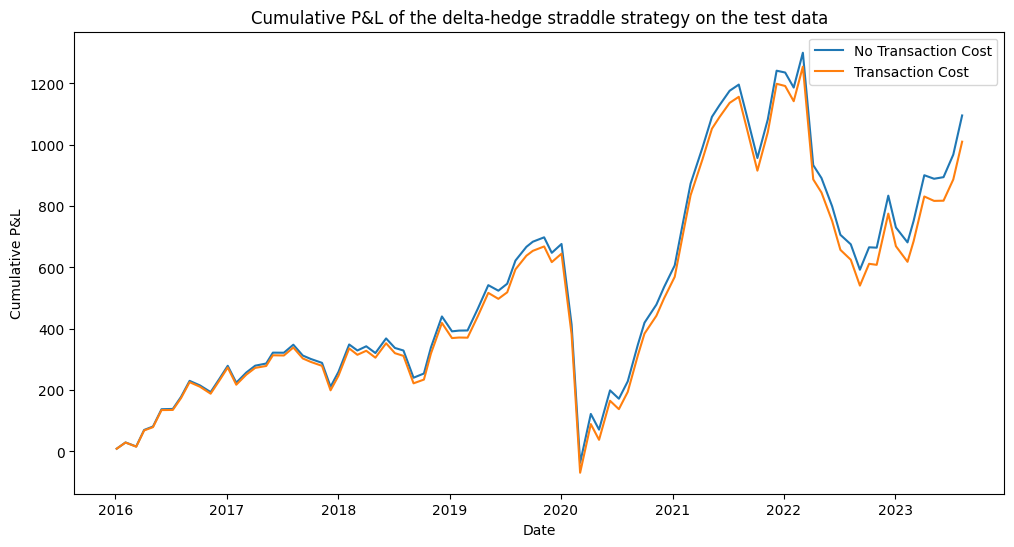

In [20]:
# Plot the cumulative P&L of the test data
plt.figure(figsize=(12, 6))
plt.plot(profit_no_cost_test['Cumulative P&L'], label='No Transaction Cost')
plt.plot(profit_cost_test['Cumulative P&L'], label='Transaction Cost')
plt.title('Cumulative P&L of the delta-hedge straddle strategy on the test data')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.legend()
plt.show()